# 🔮 05 - Forecasting Future Input Features
This notebook trains separate models to forecast each of the input features needed for price prediction:
- Solar and wind generation
- Load demand
- Gas and oil prices
- Irradiance and temperature

Each model uses past lags and calendar features to predict future values (e.g., for the next 7 days).

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Load merged dataset
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()
df.head()

,cet_cest_timestamp,DE_load_actual_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,DE_wind_capacity,DE_wind_generation_actual,Price (EUR/MWhe),DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,Gas_Price,Oil_Price
utc_timestamp,,,,,,,,,,,,
2014-12-31 23:00:00,2015-01-01T00:00:00+0100,NaN,37248.0,0.0,27913.0,NaN,NaN,NaN,NaN,NaN,3.14,55.38
2015-01-01 00:00:00,2015-01-01T01:00:00+0100,41151.0,37248.0,0.0,27913.0,8852.0,22.34,-0.981,0.0,0.0,3.14,55.38
2015-01-01 01:00:00,2015-01-01T02:00:00+0100,40135.0,37248.0,0.0,27913.0,9054.0,22.34,-1.035,0.0,0.0,3.14,55.38
2015-01-01 02:00:00,2015-01-01T03:00:00+0100,39106.0,37248.0,0.0,27913.0,9070.0,22.34,-1.109,0.0,0.0,3.14,55.38
2015-01-01 03:00:00,2015-01-01T04:00:00+0100,38765.0,37248.0,0.0,27913.0,9163.0,22.34,-1.166,0.0,0.0,3.14,55.38


## ⚙️ Forecast Each Feature

In [ ]:
# Features to forecast
features_to_forecast = ['DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency', 'Gas_Price', 'Oil_Price', 'DE_radiation_direct_horizontal','DE_radiation_diffuse_horizontal', 'DE_temperature']

# Forecast horizon (7 days)
HORIZON = 168
forecast_results = {}


📈 Forecasting: DE_solar_generation_actual
MAE: 261.23, RMSE: 500.50


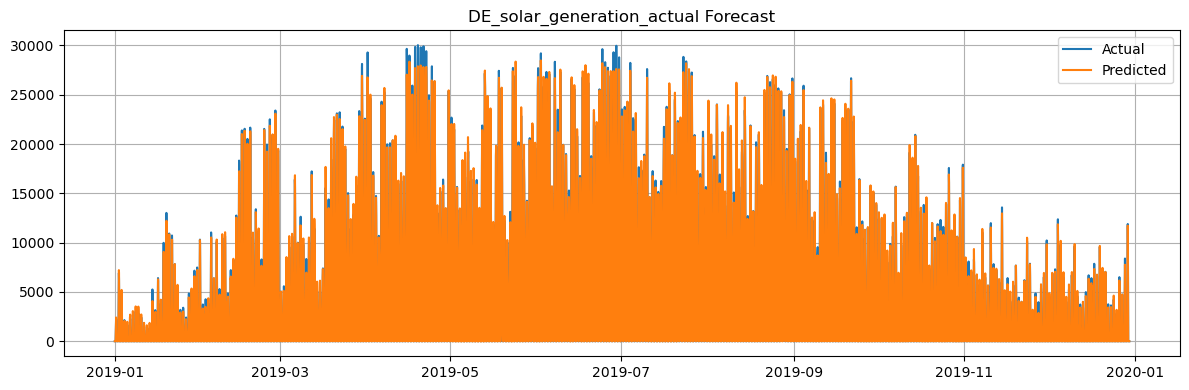


📈 Forecasting: DE_wind_generation_actual
MAE: 755.67, RMSE: 1047.27


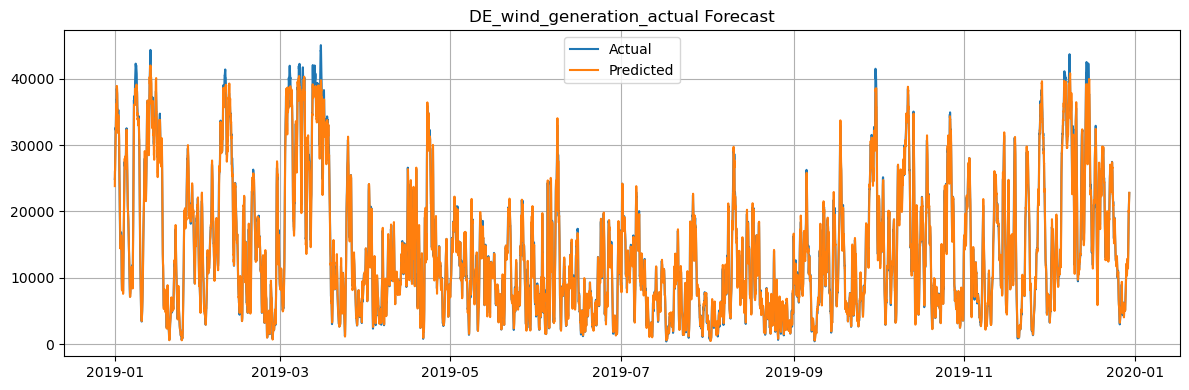


📈 Forecasting: DE_load_actual_entsoe_transparency
MAE: 508.29, RMSE: 669.62


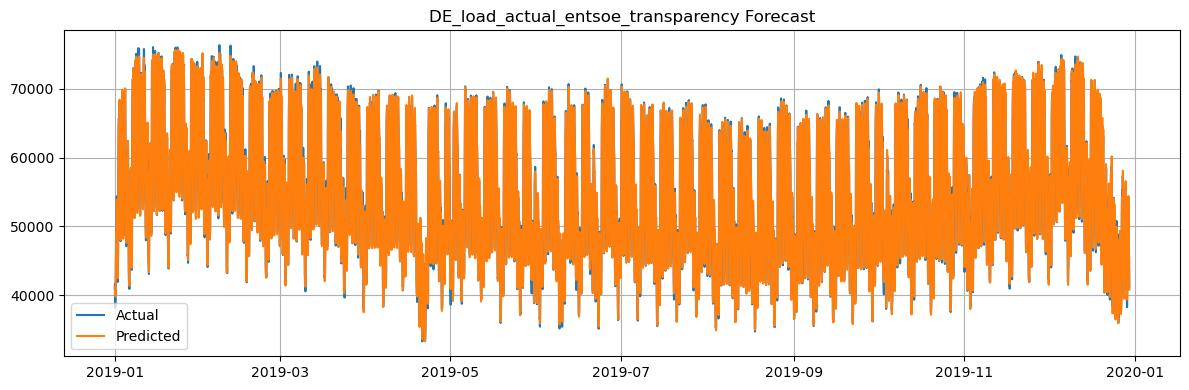


📈 Forecasting: Gas_Price
MAE: 0.01, RMSE: 0.03


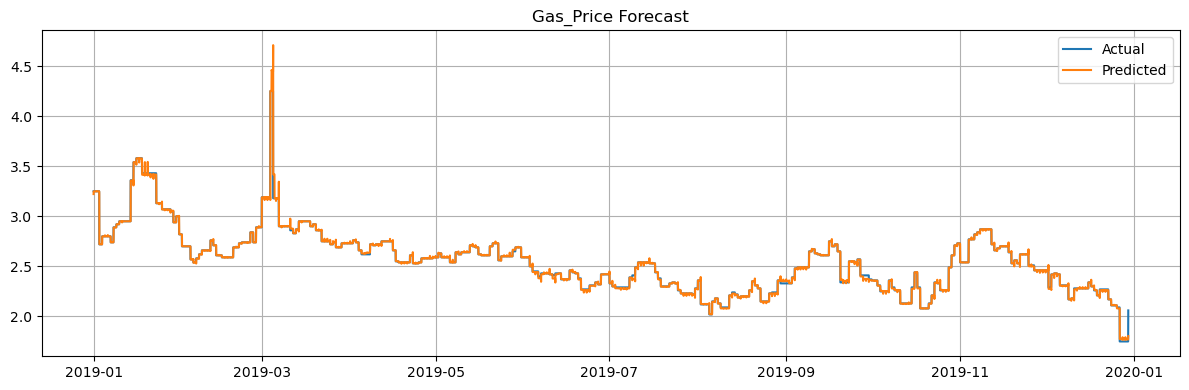


📈 Forecasting: Oil_Price
MAE: 0.16, RMSE: 0.31


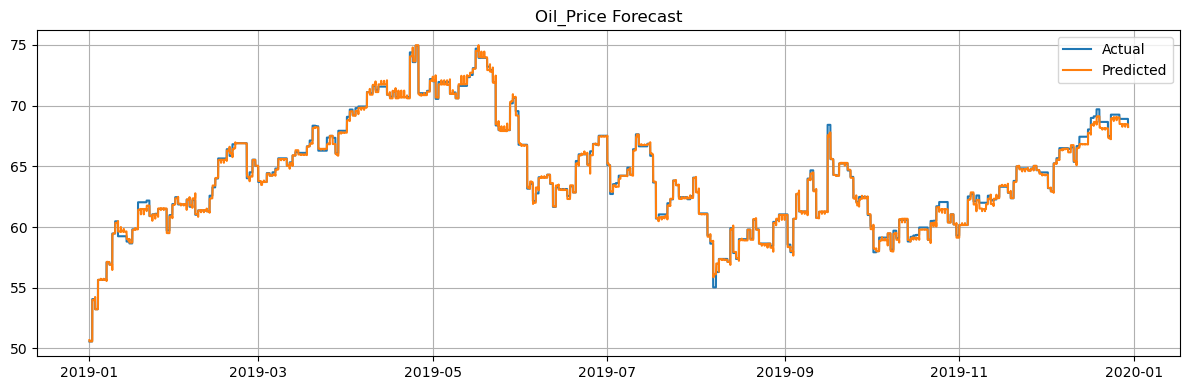


📈 Forecasting: DE_radiation_direct_horizontal
MAE: 5.98, RMSE: 13.09


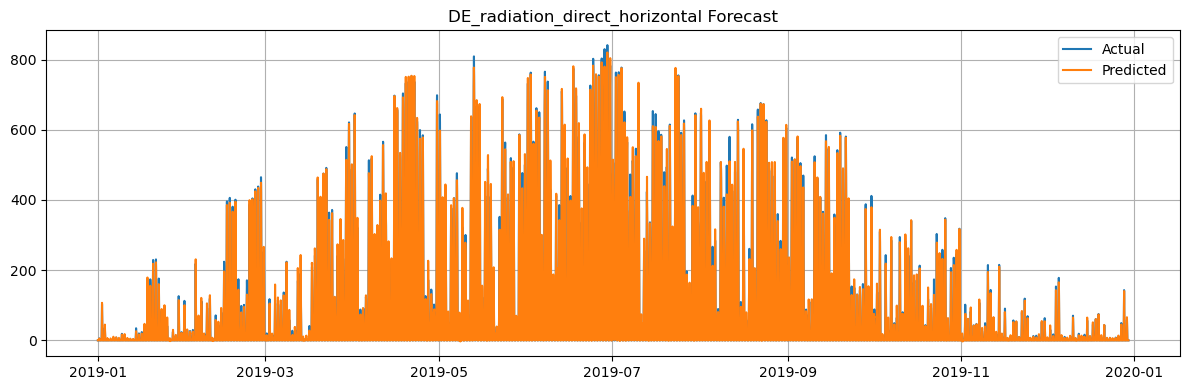


📈 Forecasting: DE_radiation_diffuse_horizontal
MAE: 4.37, RMSE: 8.49


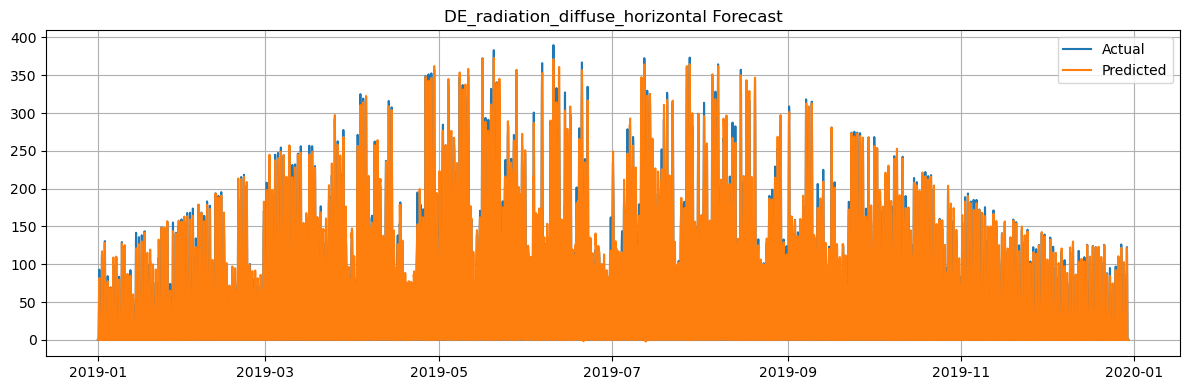


📈 Forecasting: DE_temperature
MAE: 0.25, RMSE: 0.37


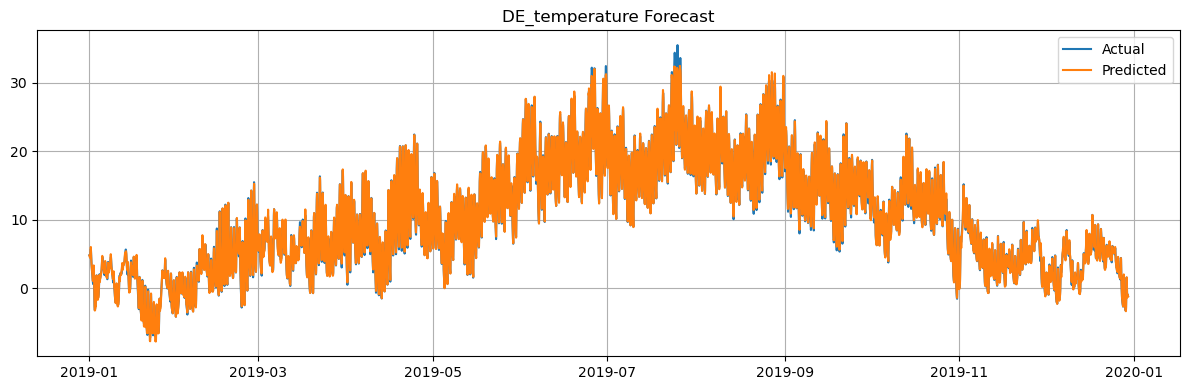

In [3]:
# Loop through each feature and train forecast model
for feature in features_to_forecast:
    print(f"\n📈 Forecasting: {feature}")
    df_feat = df[[feature]].copy()

    # Create lag features
    df_feat['lag_1h'] = df_feat[feature].shift(1)
    df_feat['lag_24h'] = df_feat[feature].shift(24)
    df_feat['lag_168h'] = df_feat[feature].shift(168)
    df_feat['roll_24h'] = df_feat[feature].rolling(24).mean()
    df_feat['roll_168h'] = df_feat[feature].rolling(168).mean()

    # Calendar features
    df_feat['hour'] = df_feat.index.hour
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month

    df_feat = df_feat.dropna()
    
    # Split train/test
    train = df_feat[df_feat.index < '2019-01-01']
    test = df_feat[df_feat.index >= '2019-01-01']

    X_train = train.drop(columns=[feature])
    y_train = train[feature]
    X_test = test.drop(columns=[feature])
    y_test = test[feature]

    # Train model
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title(f'{feature} Forecast')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    forecast_results[feature] = model

This notebook was to try and forecast the features and use this forecast to predict the energy prices accordingly</br>
However, the shortcoming of this method is that it relies on the actual data to predict the future data. Meaning it can predict the solar energy production for the next hour because it has the current hour. however, it predicts the solar energy production of the next next hour based on the test set value of the next hour which in real life is not available </br>
Finished by Jad Akra on Friday 19th of April 2025